## Data Exploration For Indian Indices
Datasets: Nifty50, Niftyauto, NiftyMidcap, NiftyNext50, NiftySmallCap, NiftyUS, 
NiftyInfra,NiftyBank,NiftyCommodities,NiftyIT, NiftyMetal,NiftyFinance, NiftyLargeCap
1. Find the least correlated datasets
2. Distribution of prices, daily returns and drawdowns
3. Identification and definition of crashes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import seaborn as sns
from pylab import rcParams
from collections import defaultdict
from scipy.optimize import curve_fit
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### 1. Find least correlated datasets
In this section, I select the datasets that will be further explored and will later be used to develop an algorithm that predicts crashes. To avoid overfitting on certain patterns and biased test sets, the datasets used should not have a strong cross correlation. 

Correlations of daily returns between datasets:


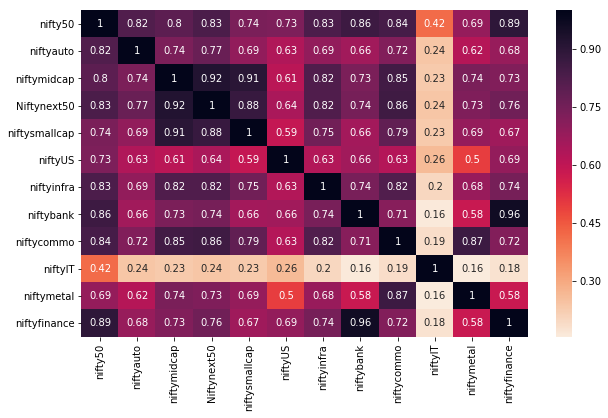

In [2]:
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\indiandata')
datasets_original_test = ['nifty50.csv', 'niftyauto.csv', 'niftymidcap50.csv', 'niftynext50.csv', 'niftysmallcap50.csv',\
'niftyUS.csv','niftyinfra.csv','niftybank.csv','niftycommodities.csv','niftyIT.csv','niftymetal.csv','niftyfinance.csv']
dataset_names_test = ['nifty50', 'niftyauto', 'niftymidcap', 'Niftynext50', 'niftysmallcap', 'niftyUS',\
                     'niftyinfra','niftybank','niftycommo','niftyIT','niftymetal','niftyfinance']

datasets_test = []
for d in datasets_original_test:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_ch = data_original['Close'].pct_change()
    datasets_test.append(data_ch)
df_returns = pd.concat(datasets_test, axis=1, join_axes=[datasets_test[0].index])
df_returns.columns = dataset_names_test
corr = df_returns.corr()
print('Correlations of daily returns between datasets:')
rcParams['figure.figsize'] = 10, 6
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

The Correlation matrix shows that the indices nifty50,niftyauto,niftymidcap,niftynext50 are highly correlated. To avoid overfitting when training prediction models, a correlation of > 0.75 for any two datasets should be avoided. Therefore, nifty50, niftymidcap, niftynext50 and niftysmallcap  will be excluded for further analysis like same nifty USD and nifty bank are highly co related so we are excluding niftyUSD for further analysis.

Correlations of daily returns between datasets (non-correlated datasets):


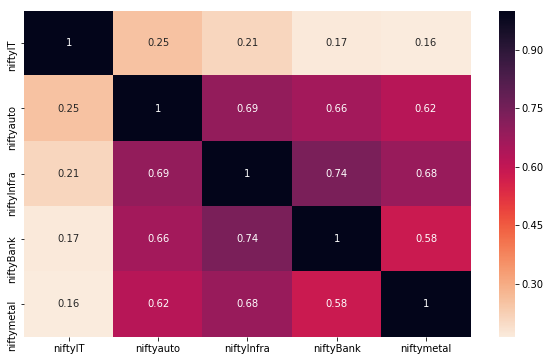

In [3]:
datasets_original = ['niftyIT.csv', 'niftyauto.csv', 'niftyinfra.csv','niftybank.csv', 'niftymetal.csv']
dataset_names = ['niftyIT', 'niftyauto', 'niftyInfra', 'niftyBank', 'niftymetal']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
# datasets[5] = datasets[5].loc['-11-09':,:]  #<-- SMI has much missing data before 11/9/90

df_ch = [d['ch'] for d in datasets]
df_returns = pd.concat(df_ch, axis=1, join_axes=[datasets[0].index])
df_returns.columns = dataset_names
corr = df_returns.corr()
print('Correlations of daily returns between datasets (non-correlated datasets):')
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

The correlation matrix with the remaining datasets shows no correlations among any two datasets of > 0.75

#### 2. Distribution of prices, daily returns, drawdowns

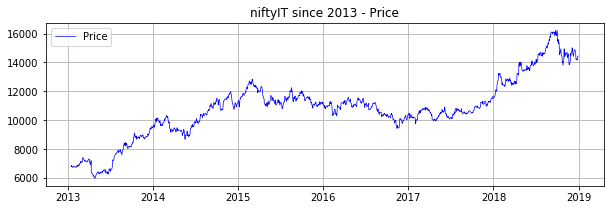

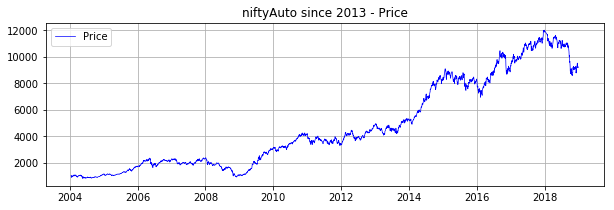

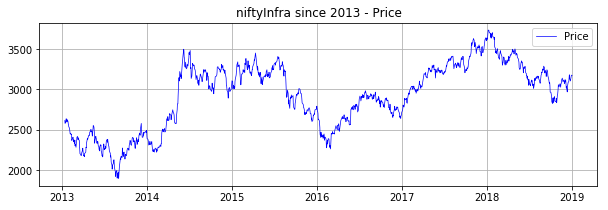

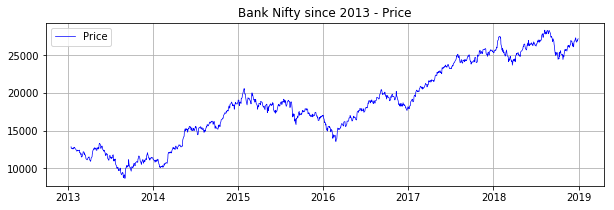

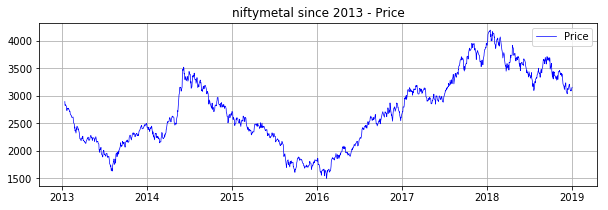

In [4]:
##### Plot price over time
rcParams['figure.figsize'] = 10, 3
plt_titles = [ 'niftyIT since 2013', 'niftyAuto since 2013', 'niftyInfra since 2013', \
              'Bank Nifty since 2013', 'niftymetal since 2013']
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['price'], color='blue', linewidth=0.7)
    plt.grid()
    plt.legend(['Price'])
    plt.title(t + ' - Price')
    plt.show()

The time series plots give an impression of the performance of the different markets over the past 50-20 years.

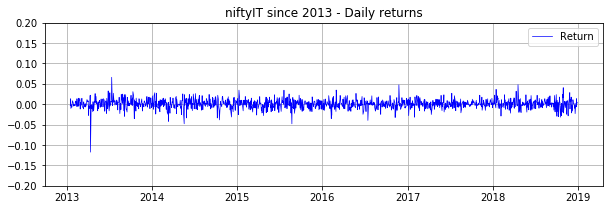

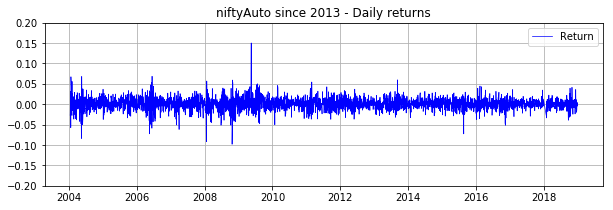

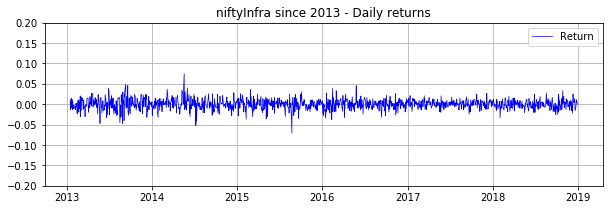

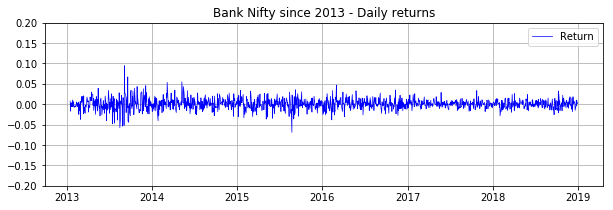

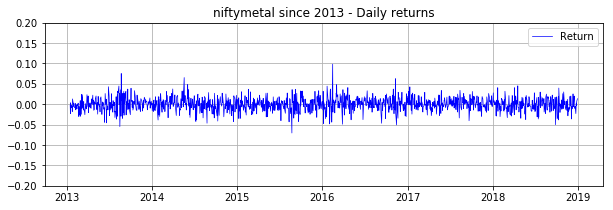

In [5]:
##### Plot daily return over time
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['ch'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(t + ' - Daily returns')
    plt.show()

The amplitude of daily returns over time for all datasets give an impression of the volatility in the different markets with the bank nifty and nifty metalshowing the larges daily gains/losses.

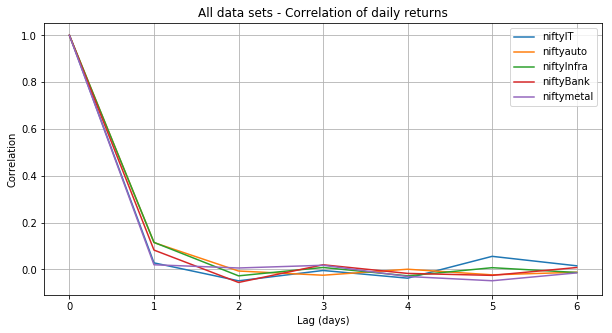

In [6]:
##### Autocorrelation
corr_ds = []
rcParams['figure.figsize'] = 10, 5
for ds, t in zip(datasets, plt_titles):
    corr = [1]
    for i in range(1, 7):
        corr.append(np.corrcoef(ds['ch'][i:], ds['ch'][:-i])[0, 1])
    plt.plot(corr)
plt.title('All data sets - Correlation of daily returns')
plt.legend(dataset_names)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

The autocorrelation of daily returns is close to zero for a lag > 1 day, indicating that the daily return is not a strong predictor for the price change of the following day.

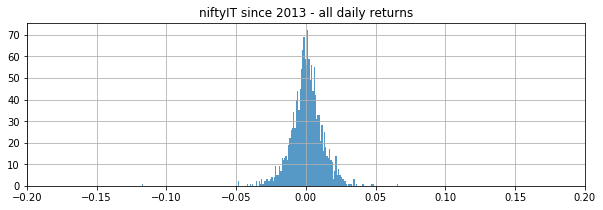

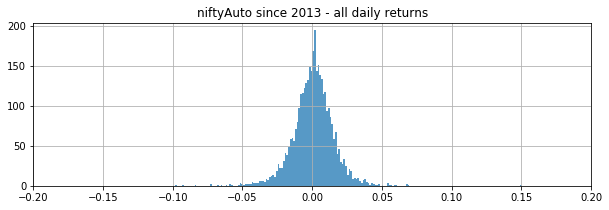

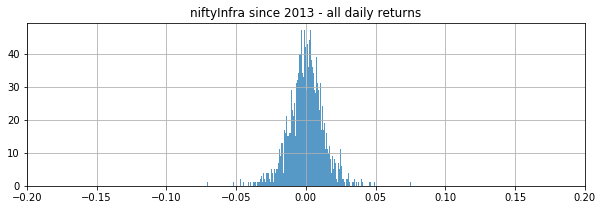

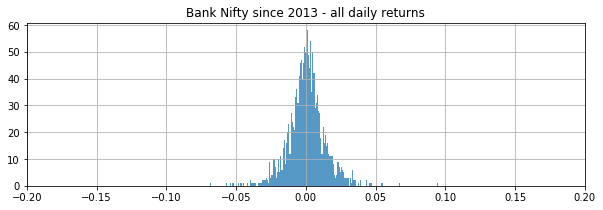

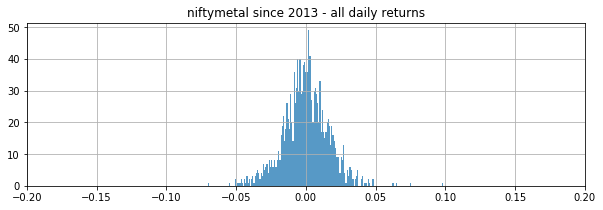

In [7]:
##### Plot distribution of daily returns
rcParams['figure.figsize'] = 10, 3
for ds, t in zip(datasets, plt_titles):
    plt.hist(ds['ch'], bins=200, rwidth=1, alpha=0.75)
    plt.xlim(-0.2, 0.2)
    plt.title(t + ' - all daily returns')
    plt.grid()
    plt.show()

The histograms for daily return distributions show that the vast majority of returns lies between -0.05 and 0.05 for all datasets. The absolute values of extreme daily gains or losses are larger than 0.1. A visual comparison between the datasets shows that the SSE and BVSP have "fat tails" indicating a realtively high volatility with a large amount of high one day gains/large one day losses.

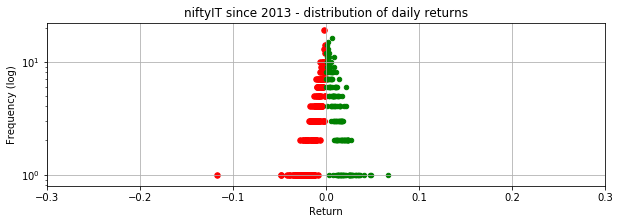

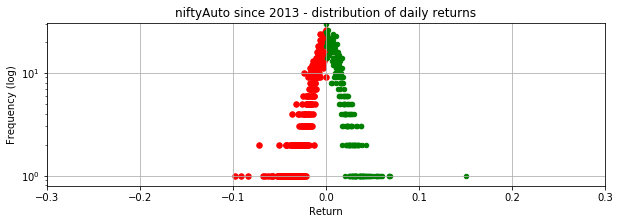

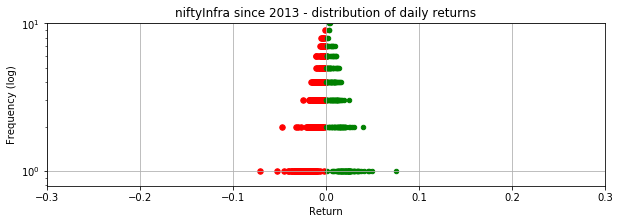

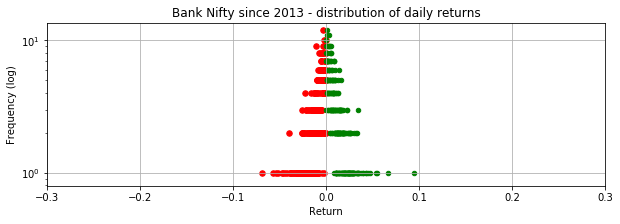

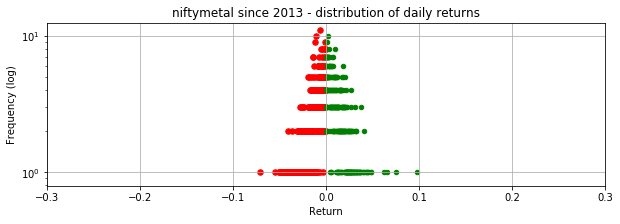

In [8]:
##### Plot log-distribution of daily returns
for ds, t in zip(datasets, plt_titles):
    max_return = max(abs(ds['ch']))
    m = round(max_return+0.01,2)
    bins = np.linspace(-m, m, 2000)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=ds['ch'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    df = pd.DataFrame(list(d1.items()))
    df.columns = ['return', 'n']
    df_neg = df[df['return']<0]
    df_neg = df_neg.sort_values(by='return', ascending=True).reset_index(drop=True)
    plt.scatter(df_neg['return'], df_neg['n'], s=30, color='red')
    plt.yscale('log')
    df_neg_reg = df_neg[df_neg['return']>-0.05]
    m, c = np.polyfit(df_neg_reg['return'], np.log(df_neg_reg['n']), 1)
    y_fit = np.exp(m*df_neg['return'] + c)
    plt.ylim(bottom=10**0)
    df_pos = df[df['return']>0]
    df_pos = df_pos.sort_values(by='return', ascending=False).reset_index(drop=True)
    plt.scatter(df_pos['return'], df_pos['n'], s=20, color='green')
    plt.yscale('log')
    df_pos_reg = df_pos[df_pos['return']<0.05]
    m, c = np.polyfit(df_pos_reg['return'], np.log(df_pos_reg['n']), 1)
    y_fit = np.exp(m*df_pos['return'] + c)
    plt.ylim(bottom=10**-0.1)
    plt.xlim(-0.3, 0.3)
    plt.title(t + ' - distribution of daily returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency (log)')
    plt.grid()
    plt.show()
    plt.show()

The frequency distribution plots show that extreme positive (red) and negtive (green) returns occur on rare instances. Extreme negative daily returns of ~0.1 and more likely contribute to a crash.

##### Drawdowns
To detect crashes, the drawdowns are calculated. A drawdown is a total loss over consequtive days from the last maximum to the nex minimum of the price. A drawdown occuring over n days (the period from t_1 to t_n) is described as d = (p_max - p_min)/pmax, with p_max = p(t_1) > p(t_2) > ... > p(t_n) = p_min.

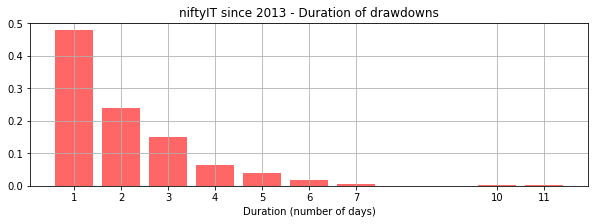

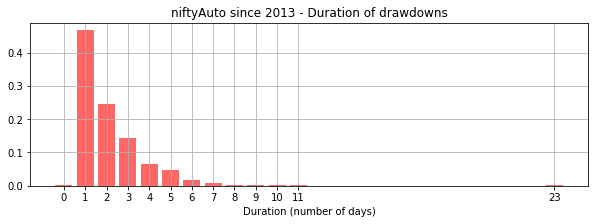

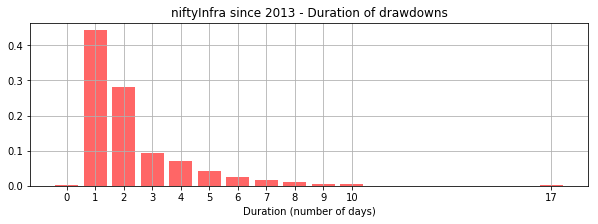

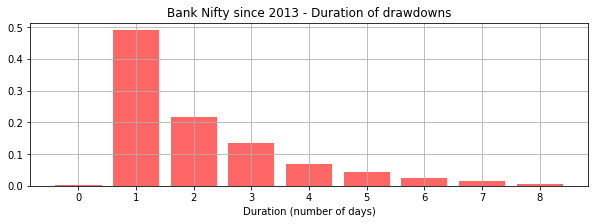

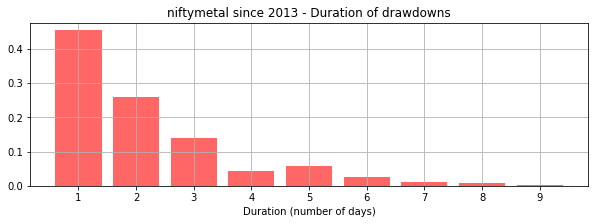

In [9]:
##### Drawdowns
dd_df = []
for ds in datasets:
    pmin_pmax = (ds['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(ds['price'][pmin.index]) - np.array(ds['price'][pmax.index])) \
        / np.array(ds['price'][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
         'duration': dur}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    dd_df.append(df_d)

# Plot duration of drawdowns
l_dict_dd = []
for dd, t in zip(dd_df, plt_titles):
    max_dd = max(abs(dd['drawdown']))
    m = round(max_dd+0.01,2)
    bins = np.linspace(-m, m, 800)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=dd['drawdown'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    l_dict_dd.append(d1)
    plt.bar(x=dd['duration'].value_counts().index, height=dd['duration'].\
        value_counts()/dd['duration'].shape[0], color='red', alpha=0.6)
    plt.xticks(dd['duration'].value_counts().index)
    plt.title(t + ' - Duration of drawdowns')
    plt.xlabel('Duration (number of days)')
    plt.grid()
    plt.show()

The duration of drawdown histograms show how long drawdowns typically last. For all datasets ~50% of all drawdowns last only one day, meaning that a price decrease from the previous to the current day is followed by a price increase on the next following day. This confirms the low autocorrelation identified earlier. The longest drawdowns last around 10-12 business days. However, the longest drawdwons are not necessasary responsible for the highest losses which will be apparent when we identify crashes.

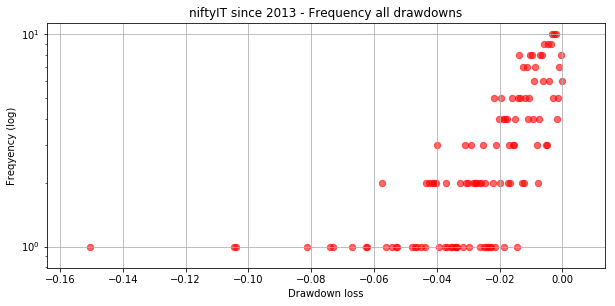

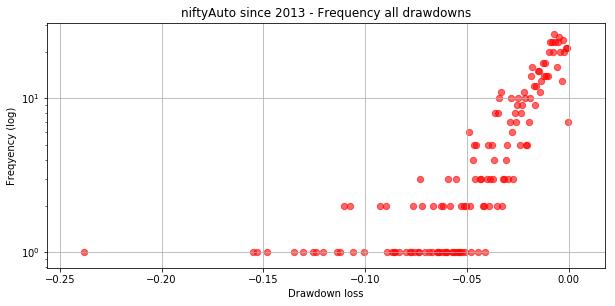

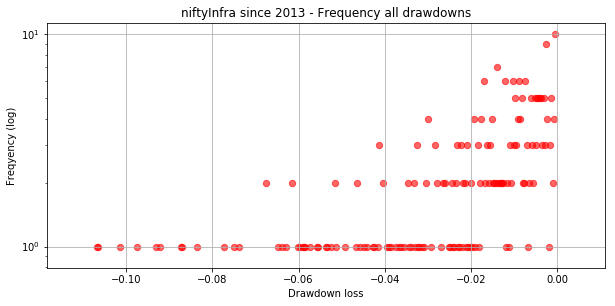

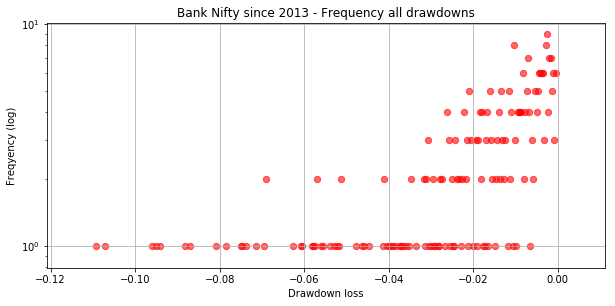

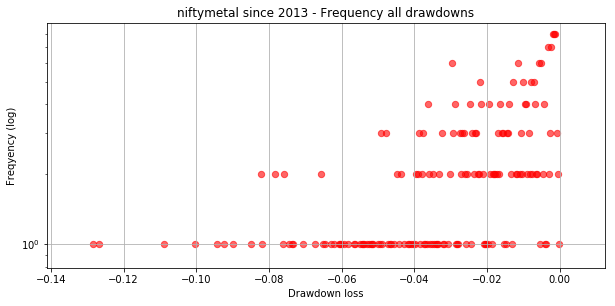

In [10]:
##### Plot frequency oof drawdowns
rcParams['figure.figsize'] = 10, 4.5
for d1, t in zip(l_dict_dd, plt_titles):
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
    m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
    y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
    #plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title(t + ' - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()

The frequency distribution plot of drawdowns shows that extreme drawdowns (> ~15%) occur on rare instances. While such large drawdowns only occured two times over nearly 70 years in the S&P, they occur much more frequently in the Indian (BSESN) or Brazilian (BVSP) market. These extreme events  are associated with crashes. Under 3. we will introduce two different methods for rules to set a threshold for drawdowns that identifies crashes.

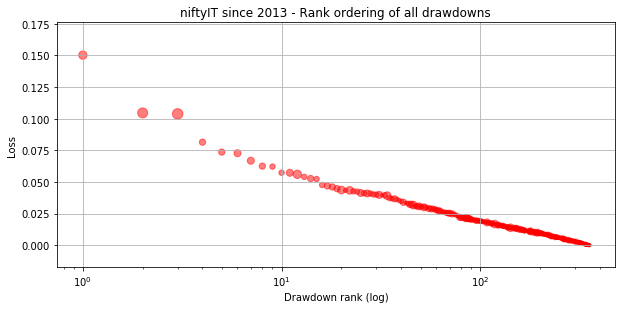

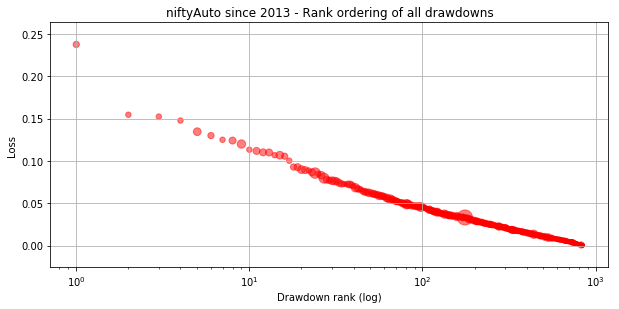

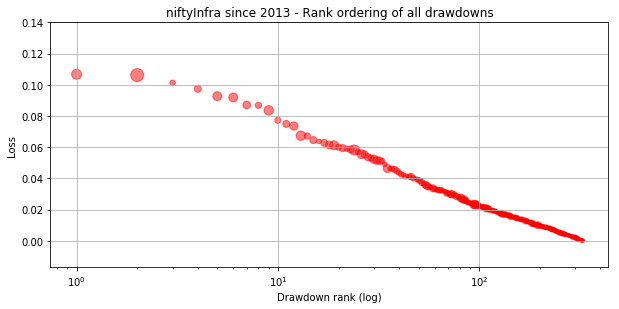

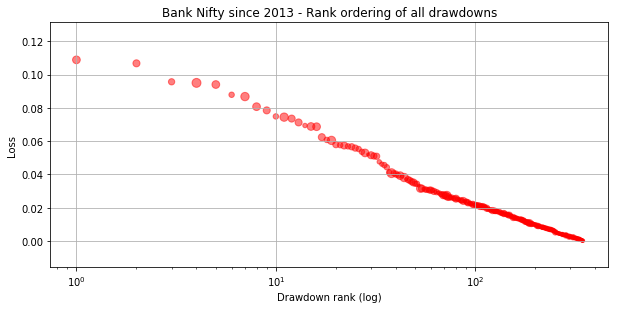

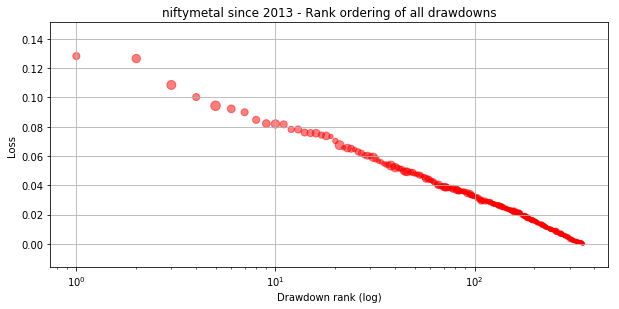

In [11]:
##### Drawdown by rank
for dd, t in zip(dd_df, plt_titles):
    plt.scatter(dd['rank'], abs(dd['drawdown']), s=10*dd['duration'], alpha=0.5,\
                color='red')
    plt.xscale('log')
    plt.title(t + ' - Rank ordering of all drawdowns')
    plt.xlabel('Drawdown rank (log)')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

For rank ordering plots above, the drawdwons have been ranked from 1 (largest drawdown in dataset) to n. The size of each bubble corresponds to the duration of each drawdown and show that the largest drawdowns are not necessarily the longest ones. These plots provide further visual evidence of the existence of outliers as drawdowns that are larger than expected.

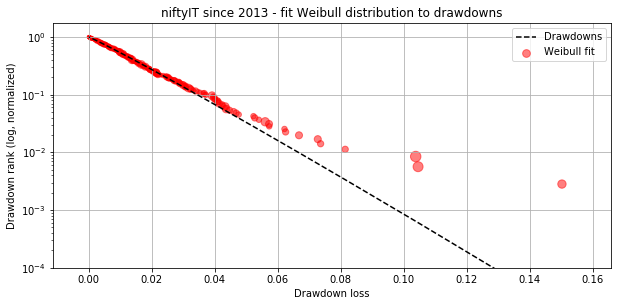

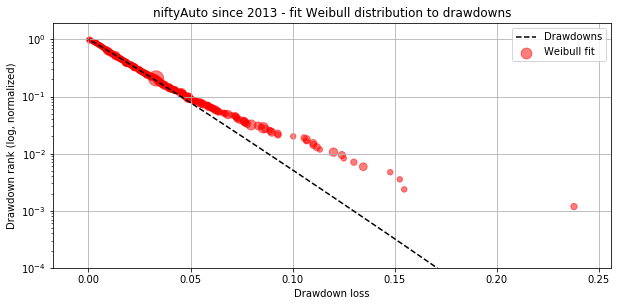

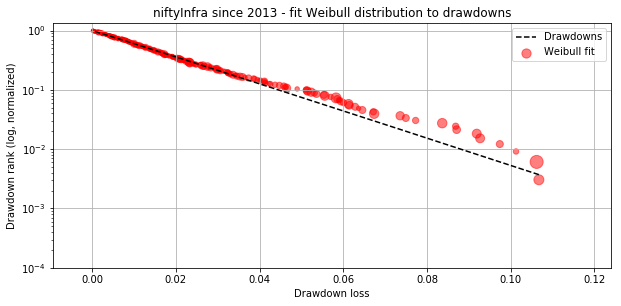

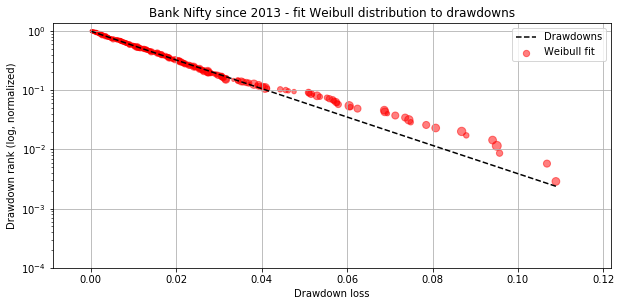

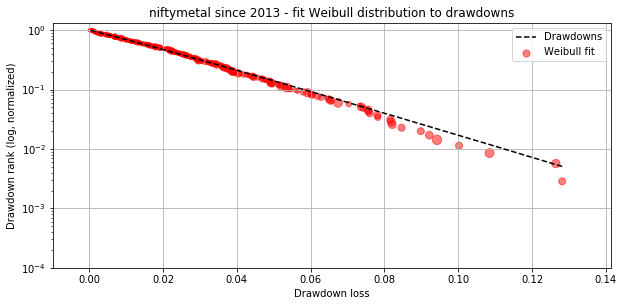

In [12]:
##### Fit Weibull exponential function to drawdowns by rank
def weibull(x, chi, z):
    return np.exp(-abs(x/chi)**z)

for dd, t in zip(dd_df, plt_titles):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x), y, s=10*dd['duration'], alpha=0.5, color='red')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Drawdowns', 'Weibull fit'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

The Weibull exponential model: y ~ exp(-abs(x/chi)^z) has been used by Johansen and Sornette (2001) to fit the distributions of drawdowns by rank. As we weill discuss below, large deviations from the Weibull distribution are considered to be crashes.

### 3. Identify Crashes
- First methodology: crashes as the 99.5% empirical quantile of the drawdowns (as suggested by Jacobsson, E., Stockholm University, in 'How to predict crashes in financial markets with the Log-Periodic Power Law', 2009).
- Second methodology: Crashes as outliers of the fitted Weibull exponential model(as suggested by Johansen, A. and Sornette, D. in 'Large Stock Market Price Drawdowns Are Outliers', 2001). This methodology requires manual identification of crashes based on the Weibull plots.

#### 3.1 Crashes according to Jaccobsen

In [13]:
##### 2.1 Emilie Jacobsen, Stockholm University: empirical quantile: 99.5%
crash_thresholds = []
for dd in dd_df:
    ct = dd['drawdown'].iloc[round(dd.shape[0] * .005)]
    crash_thresholds.append(ct)

crashes = []
for df, dd, ct in zip(datasets, dd_df, crash_thresholds):
    df_d = dd.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], dd_df[i]], axis=1).fillna(0))
jacoblist =[]
for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (99.5% drawdown quantile):')
    jacoblist.append(c)
    display(c)
    print('\n')

niftyIT since 2013 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2013-04-11,-0.150284,2013-04-11,2013-04-22,7,1
2014-12-01,-0.104603,2014-12-01,2014-12-15,10,2




niftyAuto since 2013 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2004-05-12,-0.147797,2004-05-12,2004-05-17,3,4
2006-05-17,-0.152491,2006-05-17,2006-05-22,3,3
2008-01-17,-0.154664,2008-01-17,2008-01-22,3,2
2008-10-21,-0.237810,2008-10-21,2008-10-27,4,1




niftyInfra since 2013 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2014-12-03,-0.106728,2014-12-03,2014-12-17,10,1
2015-10-16,-0.106195,2015-10-16,2015-11-10,17,2




Bank Nifty since 2013 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2013-07-23,-0.108895,2013-07-23,2013-07-31,6,1
2015-08-17,-0.106803,2015-08-17,2015-08-24,5,2




niftymetal since 2013 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2015-08-04,-0.126447,2015-08-04,2015-08-13,7,2
2015-08-17,-0.128156,2015-08-17,2015-08-24,5,1


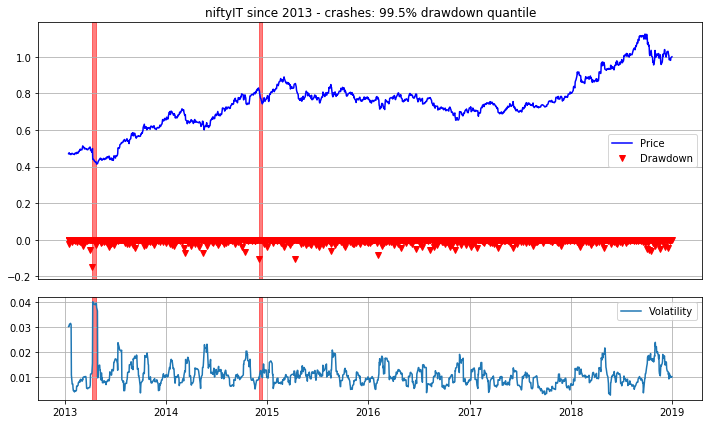

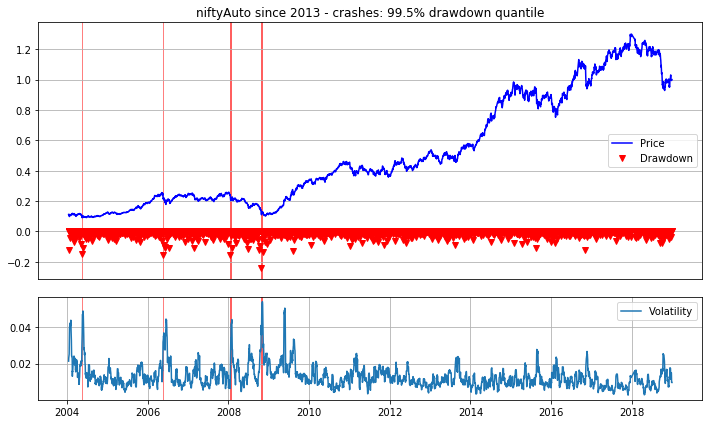

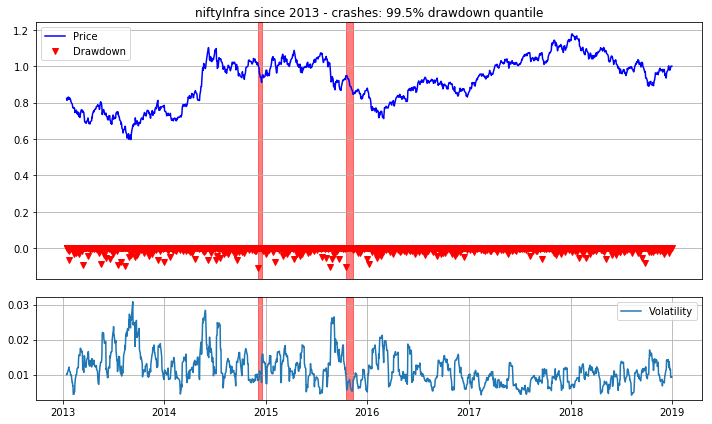

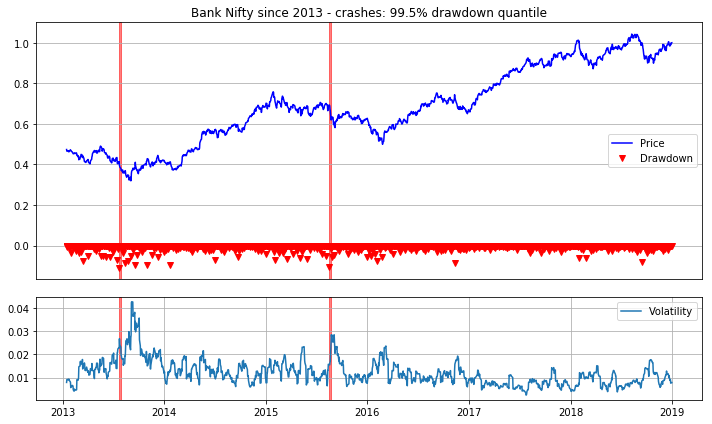

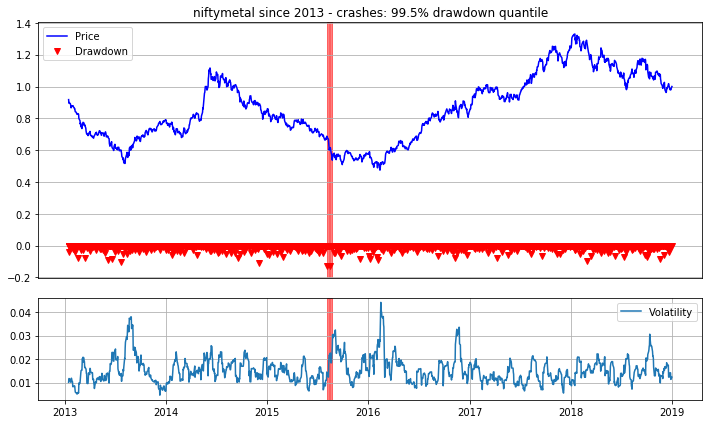

In [14]:
##### 2.1 Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: 99.5% drawdown quantile')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()


The plots above show the price (upper plots) and price return volatility with a lag of ten days (lower plots) along with the identified crases (vertical red lines) and the magnitude of the drawdowns (red pointers). Through the method of defining a crash as a drawdown in the 99.5th precentile, the number of crashes in each dataset is related to overall time period of each dataset. This leads to an identified crash occuring on average once 2-3 years. By identifying crashes through this methodology, the drawdown threshold for identifying a crash varies strongly with markets and we do not account for the fact that some markets have much more extreme large drawdowns than others.

#### 2.2 Crashes according to Johansen and Sornette

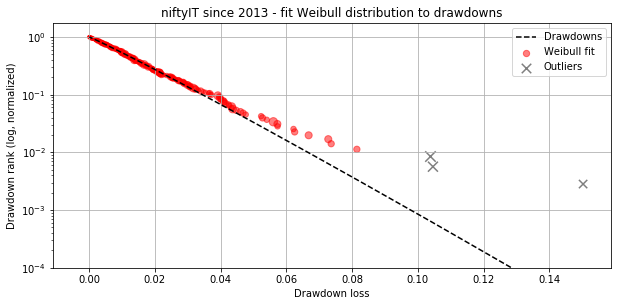

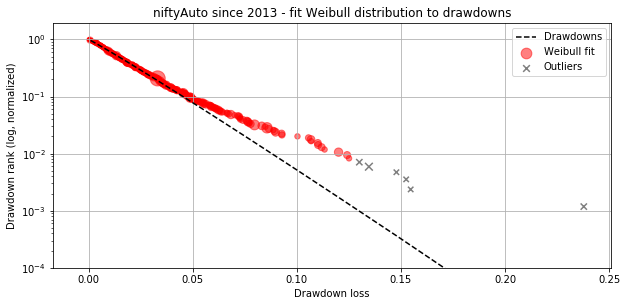

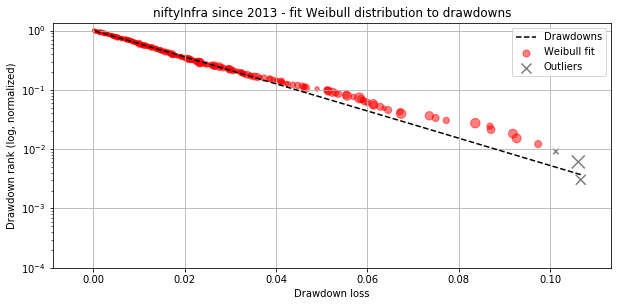

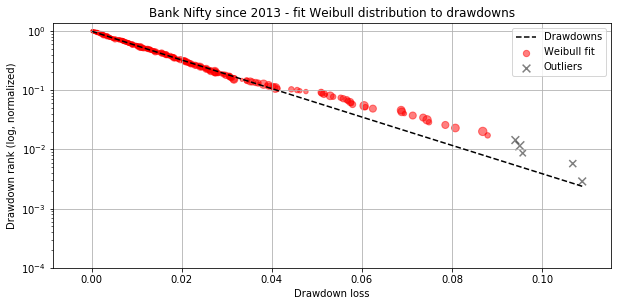

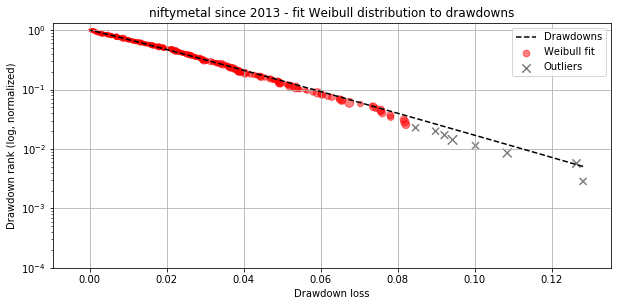

In [15]:
n_crashes = [3, 6, 3, 5, 8, 4, 11]  # <-- number of crashes manually identified based on outliers in Weibul plots below
rcParams['figure.figsize'] = 10, 4.5
for dd, t, n in zip(dd_df, plt_titles, n_crashes):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x[n:]), y[n:], s=10*dd['duration'][n:], alpha=0.5, color='red')
    plt.scatter(abs(x[:n]), y[:n], s=10*dd['duration'][:n], alpha=0.5, color='black', marker='x')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Drawdowns', 'Weibull fit', 'Outliers'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

The Weibull fit plots above are the same ones as shown under 2. but this time with the "x"s identifying outliers that cannot be explained by the Weibull distribution. As Johansen and Sornette do not give a specific threshold deviation from the distribution that identifies a crash, the identification of crashes above has been conducted based on visual interpretation.

In [16]:
crashes = []
for df, dd, r in zip(datasets, dd_df, n_crashes):
    df_c = dd[dd['rank'] <= r]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
weibulllist =[]
for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (Weibull outliers):')
    weibulllist.append(c)
    display(c)
    print('\n')

niftyIT since 2013 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2013-04-11,-0.150284,2013-04-11,2013-04-22,7,1
2014-12-01,-0.104603,2014-12-01,2014-12-15,10,2
2015-04-13,-0.103849,2015-04-13,2015-04-28,11,3




niftyAuto since 2013 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-21,-0.237810,2008-10-21,2008-10-27,4,1
2008-01-17,-0.154664,2008-01-17,2008-01-22,3,2
2006-05-17,-0.152491,2006-05-17,2006-05-22,3,3
2004-05-12,-0.147797,2004-05-12,2004-05-17,3,4
2008-11-10,-0.134602,2008-11-10,2008-11-18,6,5
2009-08-04,-0.129993,2009-08-04,2009-08-10,4,6




niftyInfra since 2013 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2014-12-03,-0.106728,2014-12-03,2014-12-17,10,1
2015-10-16,-0.106195,2015-10-16,2015-11-10,17,2
2015-08-19,-0.101273,2015-08-19,2015-08-24,3,3




Bank Nifty since 2013 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2013-07-23,-0.108895,2013-07-23,2013-07-31,6,1
2015-08-17,-0.106803,2015-08-17,2015-08-24,5,2
2013-09-19,-0.095702,2013-09-19,2013-09-25,4,3
2013-11-01,-0.095050,2013-11-01,2013-11-13,8,4
2014-01-22,-0.094063,2014-01-22,2014-01-30,6,5




niftymetal since 2013 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2015-08-17,-0.128156,2015-08-17,2015-08-24,5,1
2015-08-04,-0.126447,2015-08-04,2015-08-13,7,2
2014-12-04,-0.108465,2014-12-04,2014-12-16,8,3
2013-07-23,-0.100208,2013-07-23,2013-07-30,5,4
2018-02-26,-0.094255,2018-02-26,2018-03-09,9,5
2013-06-05,-0.092157,2013-06-05,2013-06-13,6,6
2016-02-05,-0.089852,2016-02-05,2016-02-12,5,7
2013-06-19,-0.084650,2013-06-19,2013-06-26,5,8


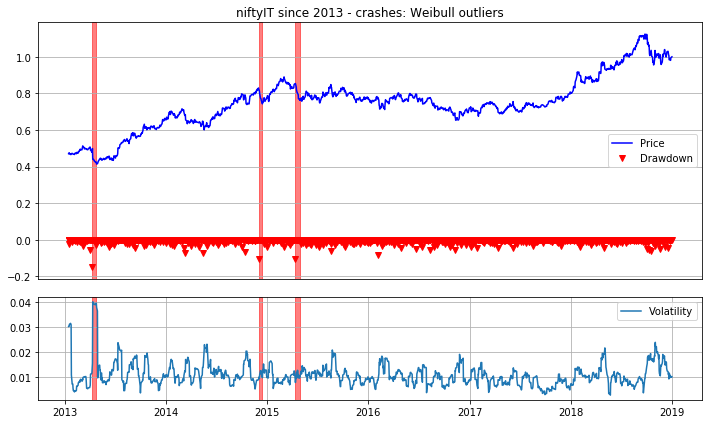

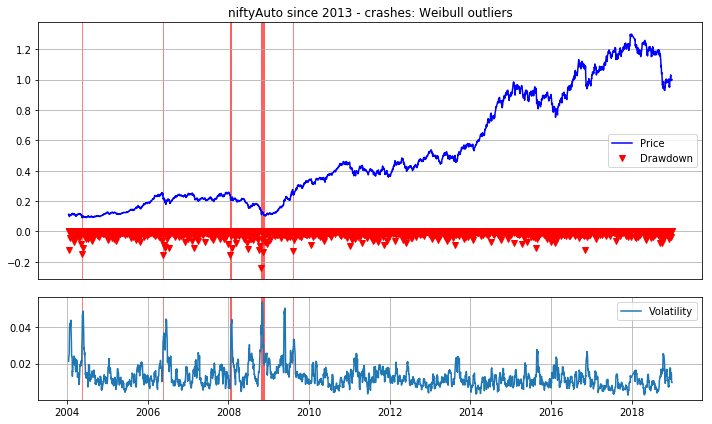

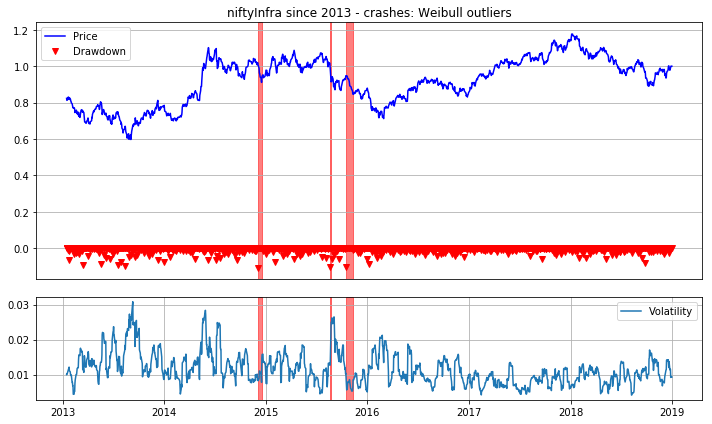

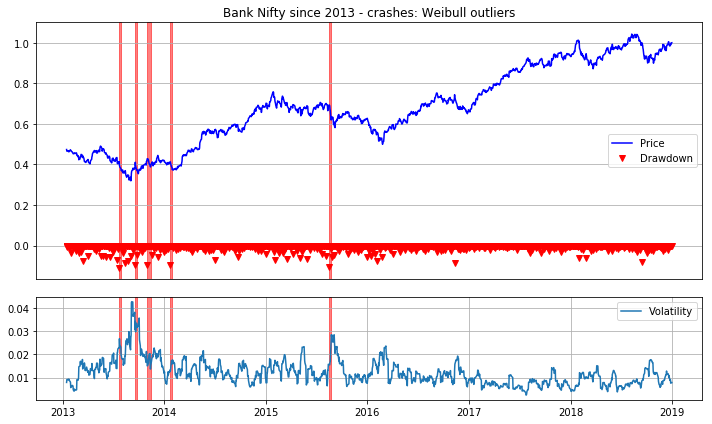

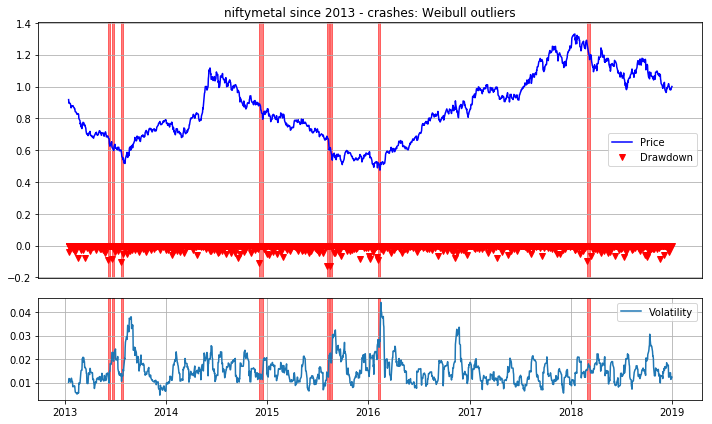

In [17]:
##### 2.2 Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: Weibull outliers')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()

Identifying crashes based on drawdown outliers results in a number of crahes that doesn't necessarily correspond to the total number of drawdowns in a dataset. There are for example only three identified crashes over 68 years in the S&P whereas there are 11 crashes in just 16 years of BVSP.

#### Conclusion
Since there is no consensus on the exact definition of a financial crash, both, the method introduced by Jacobsson (99.5% quantile of drawdowns) and the method introduced by Johansen and Sornette (outliers identified with the Weibull exponential model) can be used as an approach to identify crashes. For this project, I will be using the quantile method as it is unambiguous (no manual interpretation of outliers required) and leads to a number of crashes which proportional to the length of each dataset and therefore reduces the risk of overfitting crash patterns in certain datasets.